In [1]:
import os
import matplotlib.pyplot as plt

PATH = "afhq/train/cat"
names = os.listdir(path)
os.chdir("/content/drive/MyDrive/ddpm_implementation")

In [109]:
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])


class CustomDataset(Dataset):
    def __init__(self, names, transform=None):
        self.data = [Image.open(os.path.join(path, name)) for name in names]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        if self.transform is not None:
            sample = self.transform(sample)

        return sample

trainset = CustomDataset(names, transform)
dataloader = DataLoader(trainset, batch_size=16, shuffle = True)

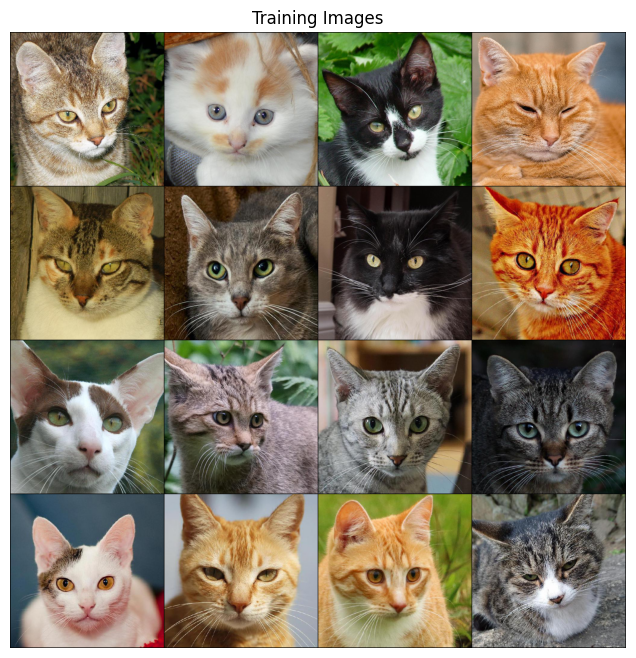

In [121]:
import torchvision.utils as vutils

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch, padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

In [16]:
# beta scheduling

T = 1000

betas = torch.linspace(10e-4, 0.02, T)
alphas = 1 - betas

pi_betas = torch.cumprod(betas, axis=0)
pi_alphas = torch.cumprod(alphas, axis=0)
pi_alphas_t_minus = torch.cat((torch.tensor([1]), pi_alphas[:-1]), dim=0)
posterior_betas = (1 - pi_alphas_t_minus) / (1 - pi_alphas) * betas

In [17]:
def get_diffused_image(x, t):
  return torch.sqrt(pi_alphas[t]) * x + torch.sqrt(1 - pi_alphas[t]) * torch.randn_like(x)

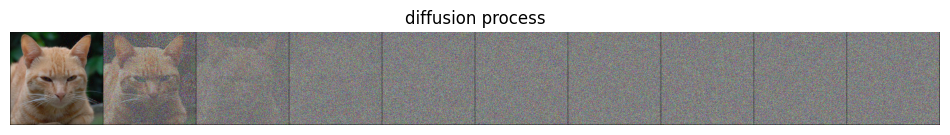

In [138]:
reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
image = next(iter(dataloader))[0]
images = [reverse_transforms(get_diffused_image(image, t_i)) for t_i in range(0, 1000, 100)]
tensor_list = [transforms.ToTensor()(image) for image in images]
minibatch = torch.stack(tensor_list)

plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("diffusion process")
plt.imshow(np.transpose(vutils.make_grid(minibatch, nrow=10),(1,2,0)))

In [ ]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_step_dim):
        super().__init__()
        self.time_step_dim = time_step_dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings